In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV, cross_validate
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import imblearn

from xgboost import XGBClassifier

In [2]:
sns.set_style('whitegrid')

In [3]:
# census = pd.read_parquet('data/refined/census_data.parquet')

In [4]:
df_mailout = pd.read_parquet('data/refined/mailout_train.parquet')

# Response variable

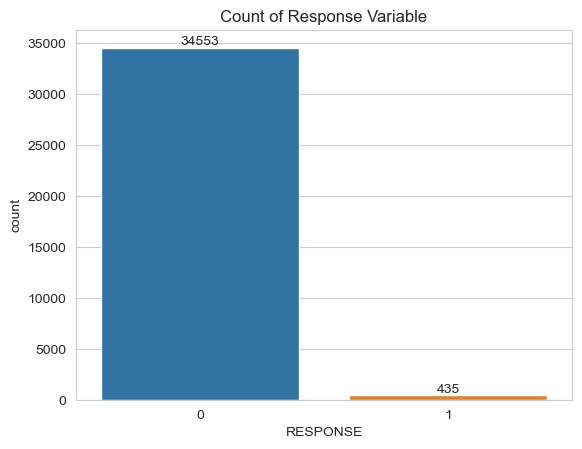

In [5]:
g = sns.countplot(data = df_mailout,
                    x = 'RESPONSE')

g.bar_label(g.containers[-1])

plt.title('Count of Response Variable')

plt.show()

In [6]:
df_mailout['RESPONSE'].value_counts(normalize = True)

0    0.987567
1    0.012433
Name: RESPONSE, dtype: float64

The data is HEAVILY imbalanced. A little more than 1% actually responded to the mailing.  
This is not inherently bad. Some methods can be used like up- or downsampling but not necessairly.  
Either way, given this hard imbalace, accuracy should not be used since in this context it is a biased metric

# Segmenting variable types

In [7]:
census_var_types = pd.read_csv('data/trusted/census_var_types.csv').drop(columns='Unnamed: 0')

In [8]:
census_var_types.head()

,Attribute,Type
0,ALTERSKATEGORIE_GROB,interval
1,ANREDE_KZ,binary
2,ANZ_HAUSHALTE_AKTIV,numeric
3,ANZ_HH_TITEL,numeric
4,ANZ_PERSONEN,numeric


In [9]:
census_var_types.loc[census_var_types['Attribute'] == 'ANZ_HH_TITEL','Type'] = 'binary'

In [10]:
census_var_types.shape

(194, 2)

In [11]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, df_mailout.columns)

In [12]:
for col in binary_vars:
    
    try:
        print(col, df_mailout[col].unique())

    except:

        print(f'Column not found: {col}')

        continue

ANREDE_KZ [2 1]
ANZ_HH_TITEL [0. 1.]
GREEN_AVANTGARDE [0 1]
OST_WEST_KZ [1. 0.]
VERS_TYP [2. 1.]


In [13]:
df_mailout['ANREDE_KZ'] = df_mailout['ANREDE_KZ'] - 1

df_mailout['VERS_TYP'] = df_mailout['VERS_TYP'] - 1

In [14]:
nominal_vars = census_var_types[census_var_types['Type'] == 'nominal']['Attribute'].values

nominal_vars = np.intersect1d(nominal_vars, df_mailout.columns)

In [15]:
interval_vars = census_var_types[census_var_types['Type'] == 'interval']['Attribute'].values

interval_vars = np.intersect1d(interval_vars, df_mailout.columns)

In [16]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, df_mailout.columns)

In [17]:
num_cols = df_mailout.columns.drop(list(nominal_vars) + list(binary_vars) + list(interval_vars) + ['LNR','RESPONSE'])

In [18]:
assert (len(nominal_vars) + len(binary_vars) + len(interval_vars) + len(num_cols) + 1) == len(df_mailout.columns.drop('RESPONSE'))

In [19]:
for var in nominal_vars:

    print(var, 'nunique:',df_mailout[var].nunique())

CJT_GESAMTTYP nunique: 6
D19_KONSUMTYP nunique: 7
FINANZTYP nunique: 6
GEBAEUDETYP nunique: 6
GEBAEUDETYP_RASTER nunique: 5
GFK_URLAUBERTYP nunique: 12
HEALTH_TYP nunique: 3
KBA05_MAXHERST nunique: 5
LP_FAMILIE_GROB nunique: 6
NATIONALITAET_KZ nunique: 3
RETOURTYP_BK_S nunique: 5
SHOPPER_TYP nunique: 4
STRUKTURTYP nunique: 3


# Testing base models
Vanilla models to pick best option for tuning

In [74]:
X = df_mailout.drop(columns = ['LNR','RESPONSE'])

X = pd.get_dummies(X,columns = nominal_vars)

y = df_mailout['RESPONSE']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
y_train.value_counts(normalize = True)

0    0.987924
1    0.012076
Name: RESPONSE, dtype: float64

In [77]:
y_test.value_counts(normalize = True)

0    0.986139
1    0.013861
Name: RESPONSE, dtype: float64

In [28]:
dt = DecisionTreeClassifier(max_depth = 10, random_state = 42, class_weight='balanced')

rf = RandomForestClassifier(max_depth = 2,class_weight='balanced',n_estimators=300, random_state=42, n_jobs=-1)

# Instantiating an XGB to match the closest possible characteristics with balanced class_weights
xgb = XGBClassifier(max_depth = 2,scale_pos_weight = 80,eta = 0.1,n_thread = 4, random_state = 42)

lr = LogisticRegression(class_weight='balanced', n_jobs = -1, random_state=42)

In [29]:
skfold = StratifiedKFold(n_splits = 5, random_state = 123, shuffle = True)

In [30]:
models_dict = {'Decision Tree':dt, 'Random Forest':rf,'XGBoost':xgb, 'LogisticRegression':lr}

In [37]:
def evaluate_models(X,y,dict_models,cv):

    for i, (name, model) in enumerate(dict_models.items()):

        scores = cross_validate(model, X, y, cv=cv, scoring=['roc_auc','f1'], n_jobs= -1, verbose = 1, return_train_score=True)

        scores['model'] = name

        if i == 0:

            records = [scores]

        else:

            records.append(scores)

    for i, r in enumerate(records):

        temp = pd.DataFrame.from_dict(r)

        if i == 0:

            results_df = temp
        
        else:

            results_df = pd.concat([results_df, temp])
        
    results_df.reset_index(inplace = True)

    results_df.rename(columns = {'index':'Fold'}, inplace = True)

    return results_df

In [38]:
results_df = evaluate_models(X_train, y_train, dict_models = models_dict, cv = skfold)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.4s remaining:   29.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


In [40]:
results_plot = results_df.melt(id_vars = ['model','Fold'], value_vars = ['test_roc_auc','train_roc_auc','test_f1','train_f1'])

,model,Fold,variable,value
0,Decision Tree,0,test_roc_auc,0.548396
1,Decision Tree,1,test_roc_auc,0.578383
2,Decision Tree,2,test_roc_auc,0.557346
3,Decision Tree,3,test_roc_auc,0.548166
4,Decision Tree,4,test_roc_auc,0.533870
...,...,...,...,...
75,LogisticRegression,0,train_f1,0.043633
76,LogisticRegression,1,train_f1,0.042374
77,LogisticRegression,2,train_f1,0.045093
78,LogisticRegression,3,train_f1,0.041261


In [41]:
results_df.groupby('model')[['test_roc_auc','train_roc_auc']].mean()

,test_roc_auc,train_roc_auc
model,,
Decision Tree,0.553232,0.885613
LogisticRegression,0.572248,0.711280
Random Forest,0.641701,0.747787
XGBoost,0.645930,0.877853


All models clearly overfit on training data

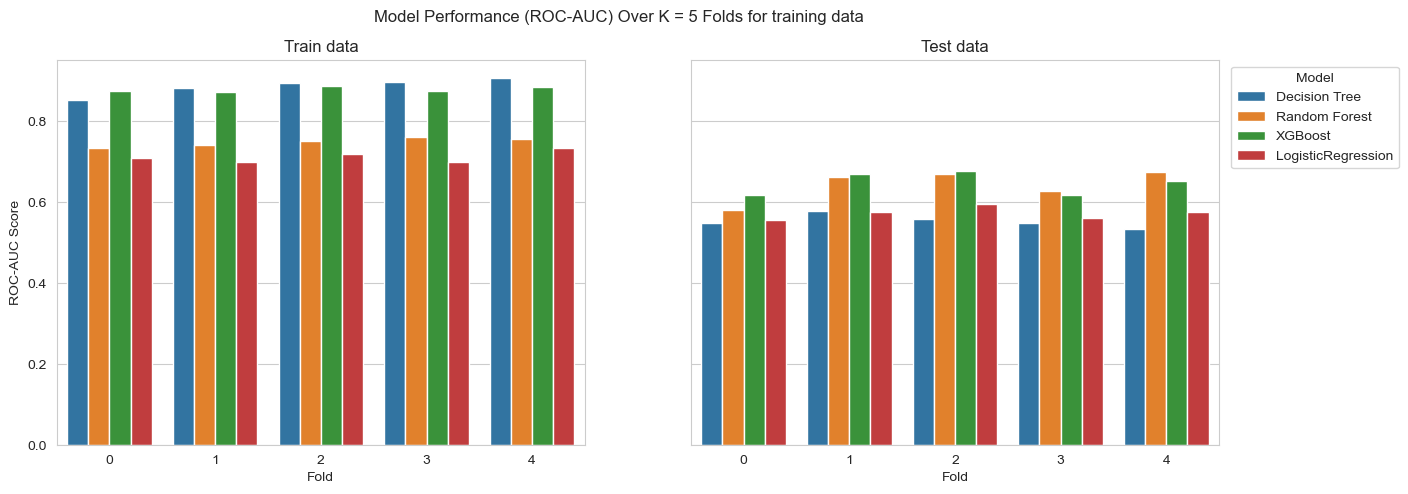

In [48]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'train_roc_auc',
                    hue = 'model',
                    ax = ax[0])

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'test_roc_auc',
                    hue = 'model',
                    ax = ax[1])

ax[0].set_ylabel('ROC-AUC Score')

ax[0].get_legend().remove()

ax[0].set_title('Train data')

ax[1].set_title('Test data')

ax[1].legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

ax[1].set_ylabel('')

for a in ax:

    a.set_xlabel('Fold')

plt.suptitle('Model Performance (ROC-AUC) Over K = 5 Folds for training data')

plt.show()

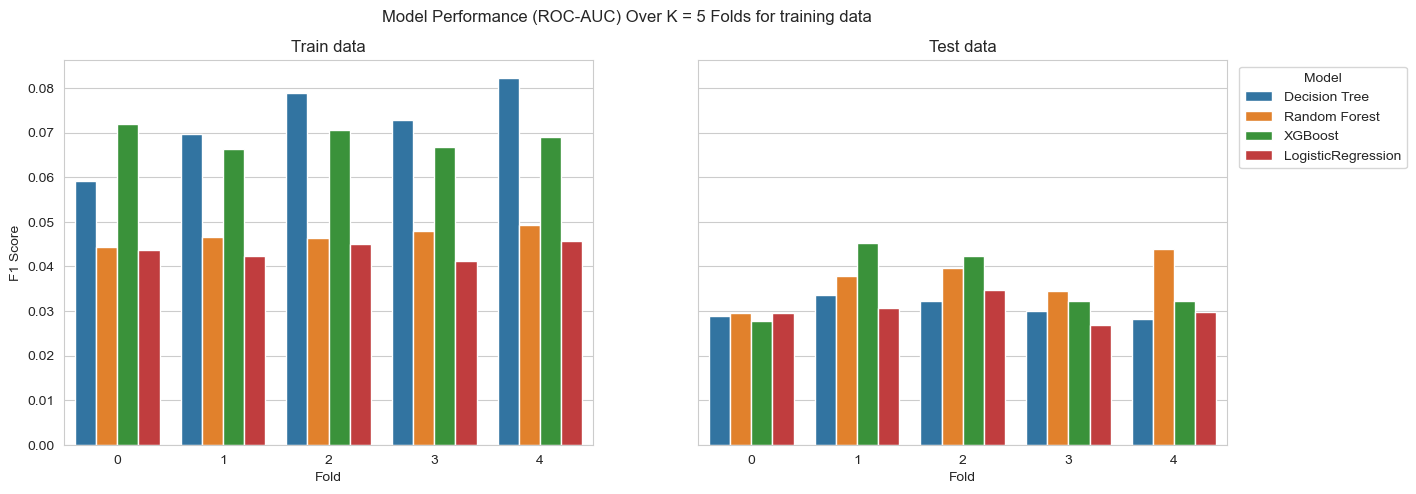

In [49]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'train_f1',
                    hue = 'model',
                    ax = ax[0])

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'test_f1',
                    hue = 'model',
                    ax = ax[1])

ax[0].set_ylabel('F1 Score')

ax[0].get_legend().remove()

ax[0].set_title('Train data')

ax[1].set_title('Test data')

ax[1].legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

ax[1].set_ylabel('')

for a in ax:

    a.set_xlabel('Fold')

plt.suptitle('Model Performance (ROC-AUC) Over K = 5 Folds for training data')

plt.show()

Even though XGBoost outperforms all models on training data, when we evaluate the models' performance on test data it becomes quite clear that there is some overfitting taking place in all cases.  
This is evident by looking into the difference between train and test metrics.  

The model that appears most constant is the Random Forest (smallest difference between training and testing datasets).  

Even by using balanced weights the algorithms are not able to capture the effects in a way to generalize well in the unbalanced sample.

# Testing Models after SMOTE

Using SMOTEC to account for nominal and binary variables

In [55]:
dummyfied_cols_list = []

for col in X:

    for n in nominal_vars:

        if col.startswith(n):

            dummyfied_cols_list.append(col)

In [59]:
cat_cols_idx_list = [X.columns.get_loc(col) for col in np.append(binary_vars, dummyfied_cols_list)]

In [86]:
len(cat_cols_idx_list)

81

In [87]:
X.shape

(34988, 229)

In [88]:
X_train.shape

(27990, 229)

In [68]:
smotenc = imblearn.over_sampling.SMOTENC(categorical_features=cat_cols_idx_list,
                                         sampling_strategy=0.1,
                                         random_state = 123)

In [91]:
X_train_rs, y_train_rs = smotenc.fit_resample(X_train.values, y_train.values)

In [98]:
results_df = evaluate_models(X_train_rs, y_train_rs, dict_models = models_dict, cv = skfold)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.6s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.2s remaining:   30.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


In [99]:
results_plot = results_df.melt(id_vars = ['model','Fold'], value_vars = ['test_roc_auc','train_roc_auc','test_f1','train_f1'])

In [100]:
results_df.groupby('model')[['test_roc_auc','train_roc_auc']].mean()

,test_roc_auc,train_roc_auc
model,,
Decision Tree,0.930205,0.986392
LogisticRegression,0.837804,0.847137
Random Forest,0.941928,0.946480
XGBoost,0.961042,0.980439


All models clearly overfit on training data

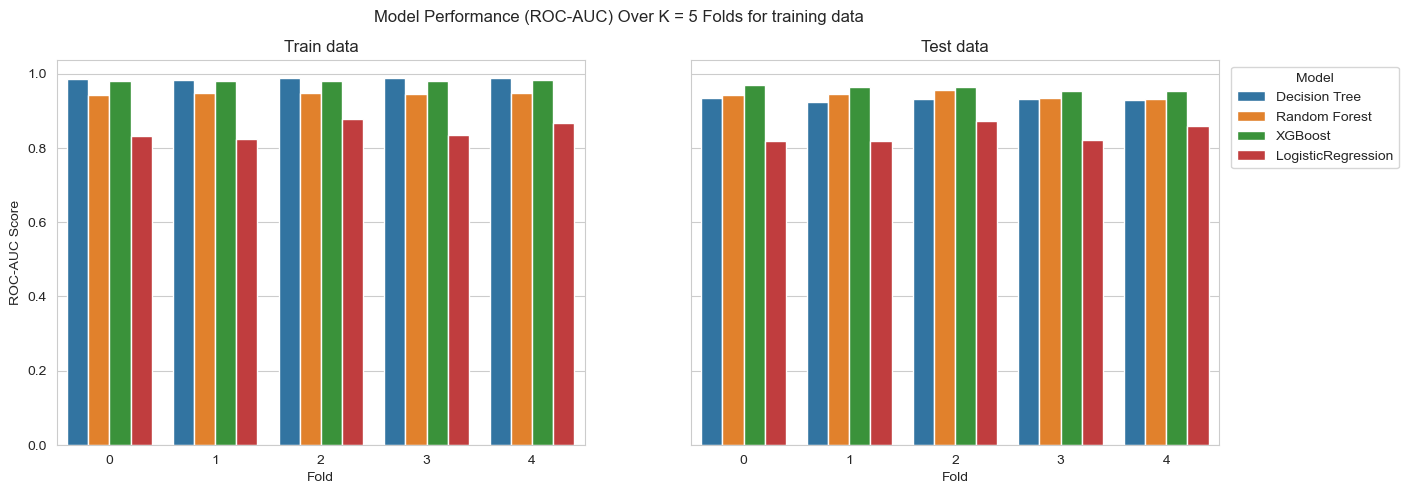

In [101]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'train_roc_auc',
                    hue = 'model',
                    ax = ax[0])

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'test_roc_auc',
                    hue = 'model',
                    ax = ax[1])

ax[0].set_ylabel('ROC-AUC Score')

ax[0].get_legend().remove()

ax[0].set_title('Train data')

ax[1].set_title('Test data')

ax[1].legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

ax[1].set_ylabel('')

for a in ax:

    a.set_xlabel('Fold')

plt.suptitle('Model Performance (ROC-AUC) Over K = 5 Folds for training data')

plt.show()

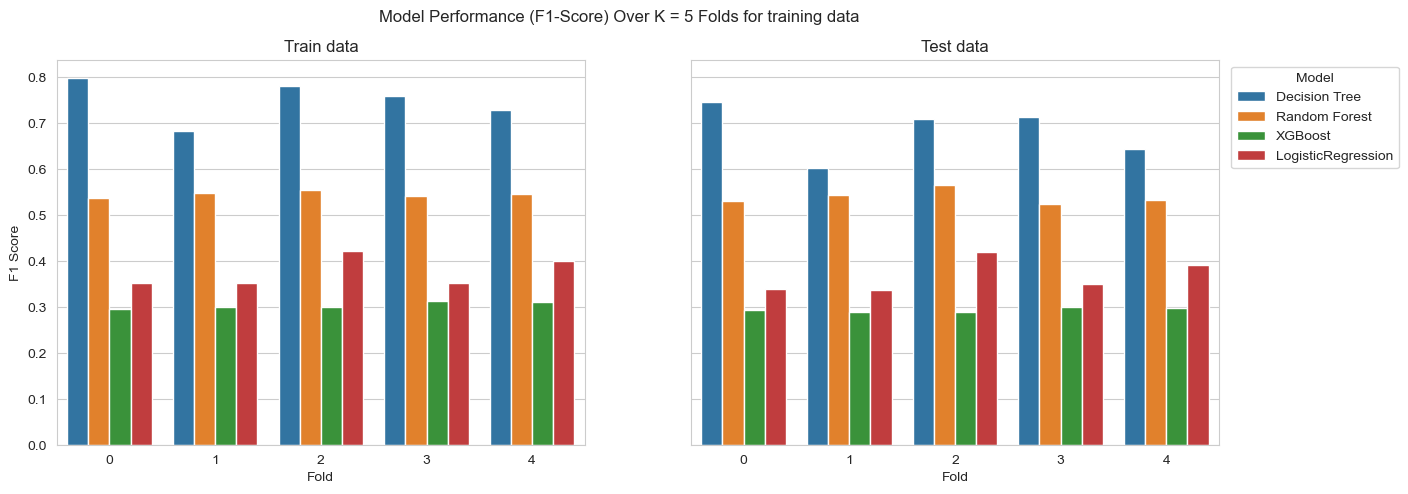

In [103]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'train_f1',
                    hue = 'model',
                    ax = ax[0])

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'test_f1',
                    hue = 'model',
                    ax = ax[1])

ax[0].set_ylabel('F1 Score')

ax[0].get_legend().remove()

ax[0].set_title('Train data')

ax[1].set_title('Test data')

ax[1].legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

ax[1].set_ylabel('')

for a in ax:

    a.set_xlabel('Fold')

plt.suptitle('Model Performance (F1-Score) Over K = 5 Folds for training data')

plt.show()

On a controlled setting, the models work way better after SMOTE. Especially a simple Decision Tree and a Random Forest.  
Decision Tree results are especially interesting because the AUC curve considers recall. For it to have such a high F1 Score, means that its high recall rate does not impact precision that much.

# Predictions on test set without SMOTE